# Objective: Predicting Incapacitiating/Fatal Injury in Car Crashes
The main objective of this notebook is to show proof of concept in predicting significant injuries in car crashes with machine learning models for a automatic emergency response notification device to utilize in vehicles. 

In [1]:
# Importing relevant libraries and dataframes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

from sklearn.linear_model import LogisticRegression


df_crashes = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv', index_col='CRASH_RECORD_ID', low_memory=False)
df_people = pd.read_csv('data/Traffic_Crashes_-_People.csv', index_col='CRASH_RECORD_ID', low_memory=False)
df_vehicles = pd.read_csv('data/Traffic_Crashes_-_Vehicles.csv', index_col='CRASH_RECORD_ID', low_memory=False)

## Data Understanding and Limitations
The data used for this project is from the City of Chicago electronic crash reporting system (E-Crash) it includes 3 dataframes involving the crash, people, and vehicles data which are merged on the unique crash record id. 

General overview:
 - Over 650k unique crashes this goes down to 580k for our modeling process after data cleaning/feature engineering
 - Time range is from 2017 to September 2022
 - Data is only in Chicago city limits and excludes all highway and freeway crashes
 - Over half of reports are desk reports aka after the crash happened and not on scene
 - Administrative error makes the data have a lot of estimates, unknowns, & NaNs

Here is a link to the source dataframes https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if



In [2]:
#This is storing the report type column for visualizations later as we drop it below for the modeling process
df_crashes2 = df_crashes.fillna('REPORT_TYPE')  
df_crashes2['REPORT_TYPE'] = df_crashes['REPORT_TYPE'].apply(lambda x: 'DESK REPORT' if x == 'NOT ON SCENE (DESK REPORT)' else 'ON SCENE')

In [3]:
#Here we are dropping columns either not relevant, too difficult to work with, or repetitive. 
crashes_columns_drop = df_crashes[['CRASH_DATE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'RD_NO', 'CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED','TRAFFIC_CONTROL_DEVICE',
                                   'DEVICE_CONDITION', 'STREET_NO',
                        'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE','PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 
                        'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'LANE_CNT','REPORT_TYPE', 'CRASH_MONTH','LATITUDE',
                        'LONGITUDE','LOCATION','INJURIES_TOTAL','INJURIES_FATAL', 'INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING',
                        'INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN','CRASH_MONTH','TRAFFICWAY_TYPE',
                        'PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE','NOT_RIGHT_OF_WAY_I','HIT_AND_RUN_I','INTERSECTION_RELATED_I']]

vehicles_columns_drop = df_vehicles[['RD_NO', 'CRASH_DATE', 'LIC_PLATE_STATE', 'AREA_00_I', 'AREA_01_I', 
                                       'AREA_02_I', 'AREA_03_I','AREA_04_I','AREA_05_I','AREA_06_I','AREA_07_I',
                                       'AREA_08_I','AREA_09_I','AREA_10_I','AREA_11_I','AREA_12_I','AREA_99_I',
                                       'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR',
                                       'CARRIER_NAME', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
                                       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 
                                       'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 
                                       'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'LOAD_TYPE', 'HAZMAT_OUT_OF_SERVICE_I',
                                        'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS', 'MAKE', 'MODEL', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 
                                       'VEHICLE_CONFIG', 'CARGO_BODY_TYPE', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_I', 'CARRIER_STATE',
                                       'FIRE_I', 'MCS_REPORT_NO','HAZMAT_VIO_CAUSE_CRASH_I','MCS_VIO_CAUSE_CRASH_I', 'TOWED_TO',
                                        'CMRC_VEH_I','VEHICLE_ID', 'OCCUPANT_CNT', 'NUM_PASSENGERS', 'TRAVEL_DIRECTION', 'MANEUVER',
                                       'VEHICLE_USE', 'CRASH_UNIT_ID', 'UNIT_TYPE']]

people_columns_drop = df_people[['RD_NO', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS',
                       'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION',
                       'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']]



df_crashes.drop(columns=crashes_columns_drop, inplace=True)
df_vehicles.drop(columns=vehicles_columns_drop, inplace=True)
df_people.drop(columns=people_columns_drop, inplace=True)

# Vehicle Dataframe mapping
This is being mapped before merging because we have to pivot this dataframe to ensure no duplicates happen upon merging it will create 2 columns for vehicles and contact points, so best to map before hand when everything is in one column.

In [4]:
#Here we are mapping and applying functions for the columns that we are going to use from the vehicle DF,
contact_map = {
    'FRONT': 'Front',                
    'OTHER' : 'Unknown',                
    'REAR-LEFT' : 'Rear',           
    'UNKNOWN' : 'Unknown',              
    'REAR' : 'Rear',                 
    'FRONT-LEFT' : 'Front',            
    'FRONT-RIGHT' : 'Front',            
    'TOTAL (ALL AREAS)' : 'Total',    
    'SIDE-RIGHT' : 'Side',           
    'SIDE-LEFT' : 'Side',          
    'ROOF' : 'Roof',                  
    'REAR-RIGHT' :'Roof',            
    'UNDER CARRIAGE' : 'Under',
    'NONE' : 'Unknown'
}

df_vehicles['Contact_Point'] = df_vehicles['FIRST_CONTACT_POINT'].map(contact_map)
df_vehicles.drop('FIRST_CONTACT_POINT', axis=1, inplace=True)

def label_vehicletype(row):
    if row['VEHICLE_TYPE'] in ['PASSENGER']:
        return 'Car'
    elif row['VEHICLE_TYPE'] in ['SPORT UTILITY VEHICLE (SUV)', 'VAN/MINI-VAN']:
        return 'SUV'
    elif row['VEHICLE_TYPE'] in ['PICKUP','TRUCK - SINGLE UNIT','SINGLE UNIT TRUCK WITH TRAILER']:
        return 'Truck'
    elif row['VEHICLE_TYPE'] in ['BUS OVER 15 PASS.','TRACTOR W/ SEMI-TRAILER','BUS UP TO 15 PASS.', 'OTHER VEHICLE WITH TRAILER', 'TRACTOR W/O SEMI-TRAILER']:
        return 'Large_vehicle'
    elif row['VEHICLE_TYPE'] in ['MOTORCYCLE (OVER 150CC)','AUTOCYCLE','MOPED OR MOTORIZED BICYCLE', 'MOTOR DRIVEN CYCLE', 'ALL-TERRAIN VEHICLE (ATV)', 
                                 '3-WHEELED MOTORCYCLE (2 REAR WHEELS)', 'RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)']:
        return 'Motorcycle'
    elif row['VEHICLE_TYPE'] in ['UNKNOWN/NA','OTHER','SNOWMOBILE', 'FARM EQUIPMENT']:
        return 'Unknown'
df_vehicles['VEHICLE_TYPE'] = df_vehicles.apply(lambda row: label_vehicletype(row), axis=1)

# People Dataframe
-kyle can you explain this process :)

In [5]:
#Here we are setting up our people df
#handling ages
Age_Series = df_people.groupby(['CRASH_RECORD_ID'])[['AGE']].agg('median')
#handling people count
Person_Count_Series = df_people.groupby(['CRASH_RECORD_ID'])[['SEX']].agg('count')
Person_Count_Series.rename(columns = {'SEX' : 'PERSON_COUNT'}, inplace = True)
#handling airbag
Airbag_Series = df_people.groupby(['CRASH_RECORD_ID'])[['AIRBAG_DEPLOYED']].first()
Airbag_Series = pd.DataFrame(Airbag_Series['AIRBAG_DEPLOYED'].str.contains('DEPLOYED'))
#handling safety 
Safety_Series = df_people.groupby(['CRASH_RECORD_ID'])[['SAFETY_EQUIPMENT']].first()
equipment_list = ['NONE PRESENT','SAFETY BELT NOT USED','HELMET NOT USED','NOT DOT COMPLIANT MOTORCYCLE HELMET',
                  'SHOULD/LAP BELT USED IMPROPERLY','CHILD RESTRAINT NOT USED','CHILD RESTRAINT USED IMPROPERLY']
Safety_Series['BOOL'] = pd.DataFrame( (Safety_Series['SAFETY_EQUIPMENT'].isin(equipment_list)))

Safety_Series["BOOL"] =  ~Safety_Series["BOOL"]
Safety_Series.loc[Safety_Series['SAFETY_EQUIPMENT'] == 'USAGE UNKNOWN', ['BOOL']] = 'Unknown'
Safety_Series = Safety_Series[['BOOL']]
Safety_Series.rename(columns = {'BOOL' : 'SAFETY_EQUIPMENT'}, inplace = True)

# Main Dataframe
So below we are merging all our above code into one final df we can map and model from.

In [6]:
#merging our people series to crashes df
df_crashes_people = df_crashes.merge(Age_Series, how='inner', on='CRASH_RECORD_ID').merge(Person_Count_Series, how='inner', on='CRASH_RECORD_ID').merge(Airbag_Series, how='inner', on='CRASH_RECORD_ID').merge(Safety_Series, how='inner', on='CRASH_RECORD_ID')

#pivoting our vehicles df for merging
pivot = pd.pivot_table(df_vehicles, columns ='UNIT_NO', index='CRASH_RECORD_ID', values ='VEHICLE_TYPE', aggfunc = 'first')
pivot2 = pd.pivot_table(df_vehicles, columns = 'UNIT_NO', index='CRASH_RECORD_ID', values = 'Contact_Point', aggfunc = 'first')

#merging our vehicle and crashes/people df to create maindf
df_main = df_crashes_people.merge(pivot.iloc[:,1:3], how='inner', on='CRASH_RECORD_ID').merge(pivot2.iloc[:,1:3], how='inner', on='CRASH_RECORD_ID')

# Setting up target:
Below we are setting up our target of fatal or incapacititating injuries, we don't want EMS coming out to every single wreck that involves a minor or no injury.

In [7]:
#Setting up our target of fatal/incapacitating injuries
df_main['FATAL/INCAPACITATING_INJURY'] = True

injury_list = ['NO INDICATION OF INJURY','NONINCAPACITATING INJURY','REPORTED, NOT EVIDENT']

df_main.loc[(df_main['MOST_SEVERE_INJURY'].isin(injury_list)) | (df_main['MOST_SEVERE_INJURY'].isna()), ['FATAL/INCAPACITATING_INJURY']] = False
df_main = df_main.drop('MOST_SEVERE_INJURY', axis = 1)

# Feature Engineering:
Below we are feature engineering relevant columns for the modeling process.

Features that we engineer are what a vehicle's systems would be able to pick up on:

- Speed
- Weather & lighting
- Road condition
- Crash type and damage
- People & Vehicle count in crash
- Age (age would only be for the driver)
- Saftey equipment deployed
- Vehicle type and contact points


In [8]:
#Here is our feature engineering in the main df to get our data ready for onehotencoding
def label_weather(row):
    if row['WEATHER_CONDITION'] in ['RAIN', 'SNOW','FREEZING RAIN/DRIZZLE','SLEET/HAIL','BLOWING SNOW']:
        return 'RAIN/SNOW'
    elif row['WEATHER_CONDITION'] in ['CLOUDY/OVERCAST', 'FOG/SMOKE/HAZE', 'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT','OTHER']:
        return 'OTHER'
    elif row['WEATHER_CONDITION'] in ['CLEAR']:
        return 'CLEAR'
    elif row['WEATHER_CONDITION'] in ['UNKNOWN']:
        return 'UNKNOWN'


df_main['WEATHER_CONDITION'] = df_main.apply(lambda row: label_weather(row), axis=1)

def label_crashtype(row):
    if row['FIRST_CRASH_TYPE'] in ['PARKED MOTOR VEHICLE','FIXED OBJECT','REAR TO REAR','REAR TO SIDE','ANIMAL','OTHER OBJECT']:
        return 'PARKED/OBJECT/SLOW'
    elif row['FIRST_CRASH_TYPE'] in ['REAR END', 'SIDESWIPE SAME DIRECTION', 'REAR TO FRONT']:
        return 'SAME DIRECTION'
    elif row['FIRST_CRASH_TYPE'] in ['HEAD ON','OVERTURNED','TRAIN']:
        return 'HEAD ON/OVERTURNED/TRAIN'
    elif row['FIRST_CRASH_TYPE'] in ['TURNING','ANGLE','SIDESWIPE OPPOSITE DIRECTION']:
        return 'ANGEL/SIDE'
    elif row['FIRST_CRASH_TYPE'] in ['PEDESTRIAN','PEDALCYCLIST','SIDESWIPE OPPOSITE DIRECTION']:
        return 'PEDESTRIAN/CYCLIST'


df_main['FIRST_CRASH_TYPE'] = df_main.apply(lambda row: label_crashtype(row), axis=1)


df_main['ALIGNMENT'] = df_main['ALIGNMENT'].apply(lambda x: 'STRAIGHT AND LEVEL' if x == 'STRAIGHT AND LEVEL' else 'NOT STRAIGHT AND LEVEL')
df_main['LIGHTING_CONDITION'] = df_main['LIGHTING_CONDITION'].apply(lambda x: 'TWILIGHT' if x == 'DUSK' or x == 'DAWN' else x)
df_main['ROADWAY_SURFACE_COND'] = df_main['ROADWAY_SURFACE_COND'].apply(lambda x: 'OTHER' if x == 'SNOW OR SLUSH' or x == 'ICE' or x =='SAND, MUD, DIRT' else x)
df_main['ROAD_DEFECT'] = df_main['ROAD_DEFECT'].apply(lambda x: 'DEFECT' if x == 'RUT, HOLES' or x == 'OTHER' or x =='WORN SURFACE' or x == 'SHOULDER DEFECT' or x == 'DEBRIS ON ROADWAY' else x)

df_main['SAFETY_EQUIPMENT'] = df_main['SAFETY_EQUIPMENT'].apply(lambda x: 'Yes' if x == True else x)
df_main['SAFETY_EQUIPMENT'] = df_main['SAFETY_EQUIPMENT'].apply(lambda x: 'No' if x == False else x)

df_main['AIRBAG_DEPLOYED'] = df_main['AIRBAG_DEPLOYED'].apply(lambda x: 'Yes' if x == True else x)
df_main['AIRBAG_DEPLOYED'] = df_main['AIRBAG_DEPLOYED'].apply(lambda x: 'No' if x == False else x)

df_main['FATAL/INCAPACITATING_INJURY'] = df_main['FATAL/INCAPACITATING_INJURY'].apply(lambda x: 1 if x == True else x)
df_main['FATAL/INCAPACITATING_INJURY'] = df_main['FATAL/INCAPACITATING_INJURY'].apply(lambda x: 0 if x == False else x)

df_main['DAMAGE'] = df_main['DAMAGE'].apply(lambda x: 'OVER $1,500' if x == 'OVER $1,500' else 'UNDER $1,500')


unit_map = {
    1 : '1',                
    2 : '2',                
    3 : '3 or more',           
    4 : '3 or more',              
    5 : '3 or more',                 
    6 : '3 or more',            
    7 : '3 or more',            
    8 : '3 or more',    
    9 : '3 or more',           
    10 : '3 or more',         
    11 : '3 or more',                  
    12 :'3 or more',            
    14 : '3 or more',
    15 : '3 or more',
    16 : '3 or more',
    18 : '3 or more',
}

df_main['NUM_UNITS'] = df_main['NUM_UNITS'].map(unit_map)

def label_speed_limits(row):
    if row['POSTED_SPEED_LIMIT'] <= 10:
        return '0 to 10 mph'
    elif row['POSTED_SPEED_LIMIT']  <= 20:
        return '11 to 20mph'
    elif row['POSTED_SPEED_LIMIT'] <= 30:
        return '21 to 30mph'
    elif row['POSTED_SPEED_LIMIT'] <= 40:
        return '31 to 40mph'
    elif row['POSTED_SPEED_LIMIT'] <= 50:
        return '41 to 50mph'
    elif row['POSTED_SPEED_LIMIT'] <= 60:
        return '51 to 60mph'
    elif row['POSTED_SPEED_LIMIT'] >= 61:
        return '61mph and over'

df_main['POSTED_SPEED_LIMIT'] = df_main.apply(lambda row: label_speed_limits(row), axis=1) 

def label_personcount(row):
    if row['PERSON_COUNT'] == 1:
        return 'One'
    elif row['PERSON_COUNT']  == 2:
        return 'Two'
    elif row['PERSON_COUNT'] == 3:
        return 'Three'
    elif row['PERSON_COUNT'] == 4:
        return 'Four'
    elif row['PERSON_COUNT'] >= 5:
        return 'Five or more'
    
df_main['PERSON_COUNT'] = df_main.apply(lambda row: label_personcount(row), axis=1) 


df_main['Vehicle1'] = df_main['1_x']
df_main['Vehicle2'] = df_main['2_x']
df_main['Contact1'] = df_main['1_y']
df_main['Contact2'] = df_main['2_y']
df_main = df_main.drop(['1_x', '2_x', '1_y', '2_y'], axis=1)

# Dropping
Below we are dropping NaN values in columns critical to our models performance

In [9]:
#dropping na values
df_main = df_main.dropna(subset = ['PERSON_COUNT', 'FIRST_CRASH_TYPE','AIRBAG_DEPLOYED', 'Vehicle1', 'Vehicle2', 'Contact1', 'Contact2'], axis = 0)

# Train Test Split and Storing Model
Here we are applying our train test split and storing df_main in a model df

In [10]:
#storing model df
model = df_main
#Train test split
X = model.drop('FATAL/INCAPACITATING_INJURY', axis = 1)
y = model['FATAL/INCAPACITATING_INJURY']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2)

# Dummy Classifier

Dummy Classifier TEST Recall Score: 0.0
Dummy Classifier TEST Precision Score: 0.0
Dummy Classifier TEST F1 Score: 0.0
Dummy Classifier TEST Accuracy Score: 0.9886898748266237


C:\Users\Clay\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


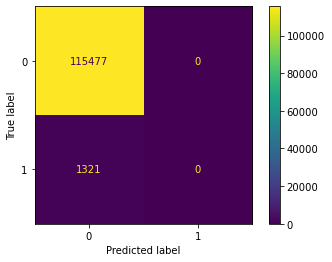

In [11]:
#Dummy classifier for baseline on evaluating our metrics 
dummy = DummyClassifier(strategy = 'most_frequent')

dummy.fit(X_train,y_train)

plot_confusion_matrix(dummy, X_test, y_test)

print('Dummy Classifier TEST Recall Score:', recall_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST Precision Score:', precision_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST F1 Score:', f1_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST Accuracy Score:', accuracy_score(y_test,dummy.predict(X_test)))

# Imputer, OneHotEncoding, and Preprocessor:

In [12]:
#setting up our Imputer, OHE, and preprocessor for pipelines 
num = ['AGE']
cat = ['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
      'ROAD_DEFECT', 'CRASH_TYPE', 'NUM_UNITS', 'PERSON_COUNT', 'AIRBAG_DEPLOYED', 'SAFETY_EQUIPMENT', 'Vehicle1', 'Vehicle2',
      'Contact1', 'Contact2', 'DAMAGE']

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median'))])

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num),
                                               ('cat', cat_transformer, cat)])


# Models

# Decision Tree

Here accuracy is the best metric, but the model is pretty obviously overfit and has way too many false negatives to be considered in a saftey device.

Training Precision:  0.8812351543942993
Testing Precision:  0.06390977443609022



Training Recall:  1.0
Testing Recall:  0.0643451930355791



Training Accuracy:  0.9985016834656489
Testing Accuracy:  0.9787581979143478



Training F1-Score:  0.9368686868686869
Testing F1-Score:  0.06412674462466994


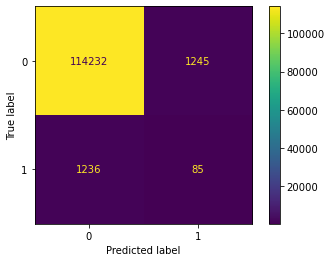

In [13]:
#Descision Tree best parameter 
dtpipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', DecisionTreeClassifier( class_weight = 'balanced'))])

dtpipe.fit(X_train,y_train)

#Evaluation of Model
y_hat_train = dtpipe.predict(X_train)
y_hat_test = dtpipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))




plot_confusion_matrix(dtpipe, X_test, y_test);

# Random Forest
Here recall is the best metric and the model appears to be fit in a good range. We are going to be focusing on recall in the future as this appears to be the best metric for judging a saftey device that wants to prevent as many false negatives as possible.

Training Precision:  0.051896227547305676
Testing Precision:  0.05286662643331322



Training Recall:  0.9990373507893724
Testing Recall:  0.9947009841029523



Training Accuracy:  0.7970765703962619
Testing Accuracy:  0.7983869586807993



Training F1-Score:  0.09866707231275314
Testing F1-Score:  0.10039731051344744


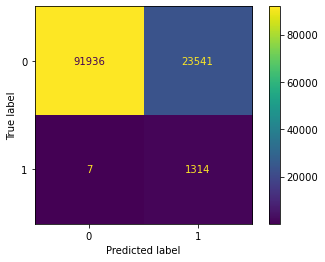

In [14]:

rfpipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier( max_depth = 10, class_weight = 'balanced_subsample'))])

rfpipe.fit(X_train,y_train)

#Evaluation of Model
y_hat_train = rfpipe.predict(X_train)
y_hat_test = rfpipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))




plot_confusion_matrix(rfpipe, X_test, y_test);

# ADA Boost
So with ADA it looks to be slightly overfit, but we get pretty good accuracy and recall if we wanted to balance those 2 metrics we would probably focus on this model.

Training Precision:  0.05608768530813941
Testing Precision:  0.05489061335437766



Training Recall:  0.9921062764728533
Testing Recall:  0.9477668433005298



Training Accuracy:  0.8142900869237635
Testing Accuracy:  0.8148427199095875



Training F1-Score:  0.10617299212922898
Testing F1-Score:  0.1037712391214256


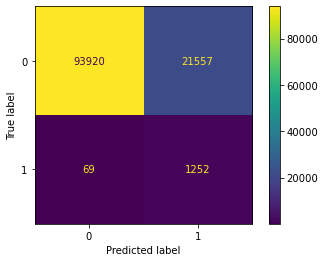

In [15]:
adapipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = 'balanced', max_depth = 3)) )])

adapipe.fit(X_train,y_train)

#Evaluation of Model
y_hat_train = adapipe.predict(X_train)
y_hat_test = adapipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))




plot_confusion_matrix(adapipe, X_test, y_test);

# Gradient Boosting
With Gradient Boosting the model is slightly overfit, this model could be used to balance both accuracy and precision, but that isn't really where we want to be for prioritizing decreasing false negatives.

Training Precision:  0.7580645161290323
Testing Precision:  0.3333333333333333



Training Recall:  0.009048902579899884
Testing Recall:  0.003785011355034065



Training Accuracy:  0.988950985785257
Testing Accuracy:  0.9886470658744156



Training F1-Score:  0.017884322678843226
Testing F1-Score:  0.007485029940119761


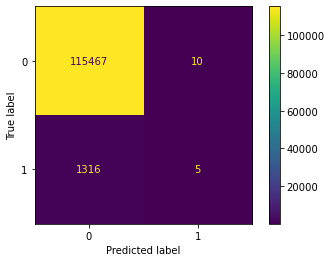

In [16]:
gbpipe = pipe4 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', GradientBoostingClassifier() )])

gbpipe.fit(X_train,y_train)

y_hat_train = gbpipe.predict(X_train)
y_hat_test = gbpipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))




plot_confusion_matrix(gbpipe, X_test, y_test);

# Logistic Regression
Logistic Regression is a great model for this, with a recall of 99% and 79% accuracy.  The false negatives are down to only 3 which is ideal for a safety device that saves lives.  However, it does run slower than our final model and so we think we can improve upon these results.. 

Training Precision:  0.0503499354488007
Testing Precision:  0.05138000935599563



Training Recall:  0.9986522911051213
Testing Recall:  0.9977289931869796



Training Accuracy:  0.7905802979937542
Testing Accuracy:  0.7916317060223634



Training F1-Score:  0.09586648554240247
Testing F1-Score:  0.09772735698661625



AUC: 0.9291901523140855


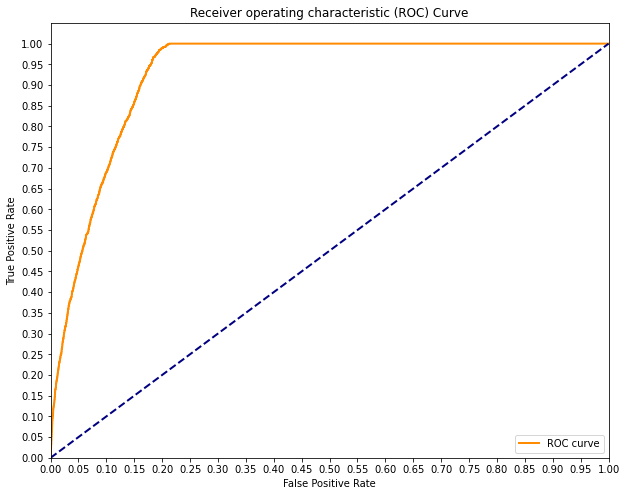

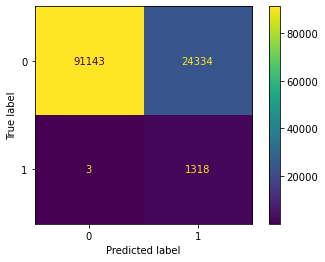

In [17]:
#Logreg pipeline with best parameters
logpipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classiffier', LogisticRegression(class_weight ='balanced', max_iter=850))])

logpipe.fit(X_train,y_train)

#Evaluation of Model
y_hat_train = logpipe.predict(X_train)
y_hat_test = logpipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

y_score = logpipe.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('\n\n')

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




plot_confusion_matrix(logpipe, X_test, y_test);

# XG Boost Final
We are going with SGBoost as the final model for implimenting a automatic emergency responce device to install in vehicles, given real time car data we feel this will preform the best for our problem.  This has a near perfect recall rate of 99.7%.

This minimizes false negatives the best and the false positives can be fixed by a simple notification system asking if the drivers are okay, no response in X amount of time and EMS is notified.  Since this target is Incapacitating/Fatal injures, the likelihood that a significant vehicle crash happened in the false positives is high.

Training Precision:  0.050359712230215826
Testing Precision:  0.05132398753894081



Training Recall:  1.0
Testing Recall:  0.9977289931869796



Training Accuracy:  0.7903555505136015
Testing Accuracy:  0.7913919758899981



Training F1-Score:  0.09589041095890412
Testing F1-Score:  0.09762601385133884


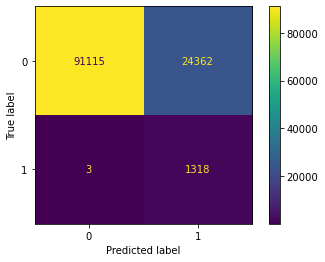

In [18]:
#XGBoost with best params
xgpipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(max_depth = 4, eta = 0.1, scale_pos_weight = 700,  tree_method = 'hist' ))])  

xgpipe.fit(X_train,y_train)

y_hat_train = xgpipe.predict(X_train)
y_hat_test = xgpipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))




plot_confusion_matrix(xgpipe, X_test, y_test);

# Visualizations in presentation

<ipython-input-19-91d5d7379ab8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  hist.set(xticklabels=['On Scene', 'Desk'])
<ipython-input-19-91d5d7379ab8>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  hist.set(yticklabels=['0', '50k', '100k', '150k', '200k', '250k', '300k', '350k']);


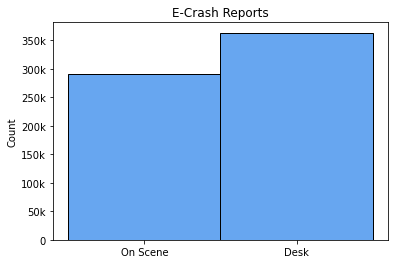

In [19]:
hist = sns.histplot(data=df_crashes2, x='REPORT_TYPE', color='#3489eb')

hist.set(xlabel=None,ylabel='Count', title='E-Crash Reports');
hist.set(xticklabels=['On Scene', 'Desk'])
hist.set(yticklabels=['0', '50k', '100k', '150k', '200k', '250k', '300k', '350k']);

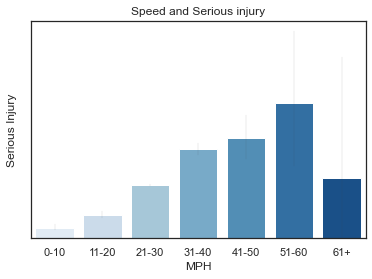

In [20]:
sns.set_theme(style="white", palette='Blues')

sns.color_palette("Blues", as_cmap=True)

bar = sns.barplot(
    data=df_main, x="POSTED_SPEED_LIMIT", y="FATAL/INCAPACITATING_INJURY",
    order=['0 to 10 mph', '11 to 20mph', '21 to 30mph', '31 to 40mph', '41 to 50mph', '51 to 60mph', '61mph and over'],
    errwidth= .1,
    palette='Blues'
)
bar.set(xlabel='MPH', ylabel='Serious Injury', title='Speed and Serious injury')
bar.set(xticklabels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61+'])
bar.set(yticklabels=[])
bar.set_xlim(-.5, 6.5);